In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Execution

In [2]:
df = pd.read_parquet("../ETL/data/engineered/final_data_2025Q1.parquet")

In [3]:
df.head()

,side,log_dollar_value,role,is_10b5_1,log_size_vs_cap,label_up_market
3,sell,15.441086,OFFICER,0,-9.087956,1
4,sell,14.496378,DIRECTOR,0,-10.032665,1
5,buy,13.401964,OFFICER,0,-9.559271,1
6,sell,14.673079,OFFICER,1,-10.128313,0
7,sell,11.586464,DIRECTOR,1,-13.214937,0


In [4]:
df.shape

(5924, 6)

In [5]:
target_col = "label_up_market"
X = df.drop(columns=[target_col])
y = df[target_col]

In [6]:
default_accuracy = y.value_counts().max() / len(y)
print("Default (baseline) accuracy:", default_accuracy)

Default (baseline) accuracy: 0.6068534773801485


In [7]:
categorical_cols = ["side", "role"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

In [8]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
    ]
)

In [9]:
knn = KNeighborsClassifier()

In [10]:
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("knn", knn)
])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [12]:
""" param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan", "minkowski"]
}
"""

param_grid = {
    'knn__n_neighbors': [11, 15, 21, 25, 31],
    'knn__weights': ['distance'],
    'knn__metric': [
        'euclidean',   # Minkowski(p=2)
        'manhattan',   # Minkowski(p=1)
        'chebyshev',   # L-infinity norm
        'minkowski'    # general p
    ],
    'knn__p': [1.2, 1.5, 1.7]
}


In [13]:
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['side',
                                                                          'role']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['log_dollar_value',
                                                                          'is_10b5_1',
                                                                          'log_size_vs_cap'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'chebyshev',
                                         'minkowski'],
                         'knn__n_neighbors': [11, 15, 21, 25, 31],
                         'knn__p': [1.2, 1.5, 1.7],
                         'knn__weights': ['distance']},
             scoring='accuracy', verbose=1)

limit_output extension: Maximum message size of 10000 exceeded with 36794 characters

In [14]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_

print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'knn__metric': 'chebyshev', 'knn__n_neighbors': 31, 'knn__p': 1.2, 'knn__weights': 'distance'}


In [15]:
# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# ---- Accuracy scores ----
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)


print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")

Train Accuracy: 0.9995
Test Accuracy:  0.6374


In [16]:
# ---- Confusion matrix on test set ----
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Test):")
print(cm)


Confusion Matrix (Test):
[[699 200]
 [337 245]]


In [17]:
# ---- Classification report on test set ----
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))



Classification Report (Test):
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       899
           1       0.55      0.42      0.48       582

    accuracy                           0.64      1481
   macro avg       0.61      0.60      0.60      1481
weighted avg       0.63      0.64      0.63      1481



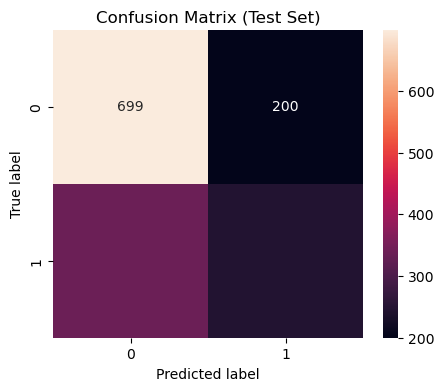

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# **Model Interpretation & Inferences (KNN Classification)**

## **Overall accuracy (0.637) shows improvement over baseline**

The optimized KNN model achieved **0.637 accuracy**, higher than the baseline (0.606). The model benefits from distance weighting, Chebyshev distance, and a larger neighborhood size (k = 31), which produce more stable predictions.

---

## **Class 0 (Not-Up Market) → Strong performance**

* **Recall = 0.78**
* **Precision = 0.67**

The model correctly identifies most non-upward cases, reflecting the dominant pattern in the data.

---

## **Class 1 (Up-Market) → Moderate performance**

* **Recall = 0.42**
* **Precision = 0.55**

The model detects a moderate portion of true upward movements, showing improvement over simpler models but still limited by class imbalance and noisy patterns.

---

## **Reasons for improved Class 1 detection**

* **Chebyshev distance** emphasizes the most informative feature difference.
* **Distance weighting** gives closer neighbors more influence.
* **Large k (31)** reduces noise and stabilizes predictions.
* **Feature scaling** ensures distances are comparable.

---

## **Why Class 1 remains harder to predict**

* **Class imbalance** reduces local representation of Class 1 in neighborhoods.
* **Weak predictive signal** in the available features.
* **Local nature of KNN** causes difficulty when minority examples are sparse.
